# 😷 Face Mask Detector



## 📋 Sobre o Projeto

Este projeto implementa um classificador de imagens para detectar o uso de máscaras faciais.

O objetivo é criar um modelo leve e eficiente, capaz de rodar em dispositivos embarcados (como ESP32-CAM),

utilizando **Transfer Learning** com a arquitetura **MobileNetV2**.



## 🎯 Fases do Projeto

1. **Preparação dos Dados**: Download e pré-processamento.

2. **Data Augmentation**: Aumento sintético do dataset para evitar overfitting.

3. **Transfer Learning (Fase 1)**: Treinamento apenas do classificador (Feature Extraction).

4. **Fine-Tuning (Fase 2)**: Ajuste fino das últimas camadas da base pré-treinada.

5. **Avaliação**: Teste com um dataset externo para garantir generalização.

6. **Exportação**: Conversão para TFLite (INT8) para uso em microcontroladores.



---



## 1. 🛠️ Configuração Inicial e Importações

Importação das bibliotecas essenciais e definição de constantes globais.



In [46]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Utilitários do Keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configurações de GPU (Opcional)
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"✅ GPU Detectada: {physical_devices[0]}")
    else:
        print("⚠️ Nenhuma GPU detectada. O treinamento será mais lento na CPU.")
except Exception as e:
    print(f"Erro na configuração de GPU: {e}")

# Constantes e Hiperparâmetros
BATCH_SIZE = 32
IMG_SIZE = (96, 96)  # Tamanho reduzido para performance em borda
IMG_SHAPE = IMG_SIZE + (3,)
SEED = 42

print(f"Versão do TensorFlow: {tf.__version__}")


⚠️ Nenhuma GPU detectada. O treinamento será mais lento na CPU.
Versão do TensorFlow: 2.20.0


## 2. 📥 Download e Carregamento dos Dados

Utilizamos o **KaggleHub** para baixar o dataset automaticamente.



**Dataset Principal**: [Face Mask Dataset](https://www.kaggle.com/datasets/omkargurav/face-mask-dataset)



In [47]:
print("⬇️ Baixando Dataset de Treino...")
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
DATA_DIR = os.path.join(path, "data")
print(f"📂 Caminho do dataset: {DATA_DIR}")


⬇️ Baixando Dataset de Treino...
📂 Caminho do dataset: C:\Users\josel\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1\data


### 2.1 Criação dos Datasets (Treino e Validação)

Divisão 80/20 garantindo shuffle para evitar vieses.



In [48]:
print("🔄 Carregando imagens...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

class_names = train_dataset.class_names
print(f"🏷️ Classes encontradas: {class_names}")


🔄 Carregando imagens...
Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.
🏷️ Classes encontradas: ['with_mask', 'without_mask']


## 3. 🎨 Visualização Exploratória

Verificar se os dados foram carregados corretamente é crucial antes de prosseguir.



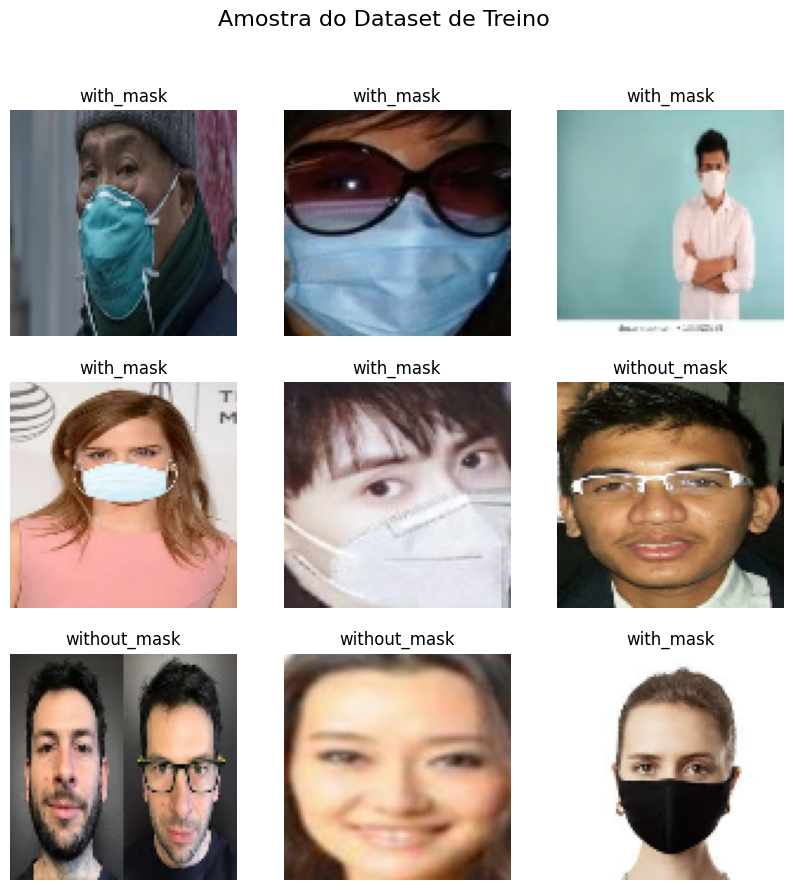

In [49]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Amostra do Dataset de Treino", fontsize=16)
plt.show()


## 4. ⚙️ Pré-processamento e Data Augmentation



### Estratégia

1. **Data Augmentation**: Aplicado *apenas* no treino para aumentar a variabilidade e robustez.

2. **Normalização**: As imagens são normalizadas para o intervalo [-1, 1], esperado pela MobileNetV2.

3. **Performance**: Uso de `AUTOTUNE` para carregar dados em paralelo (prefetching).



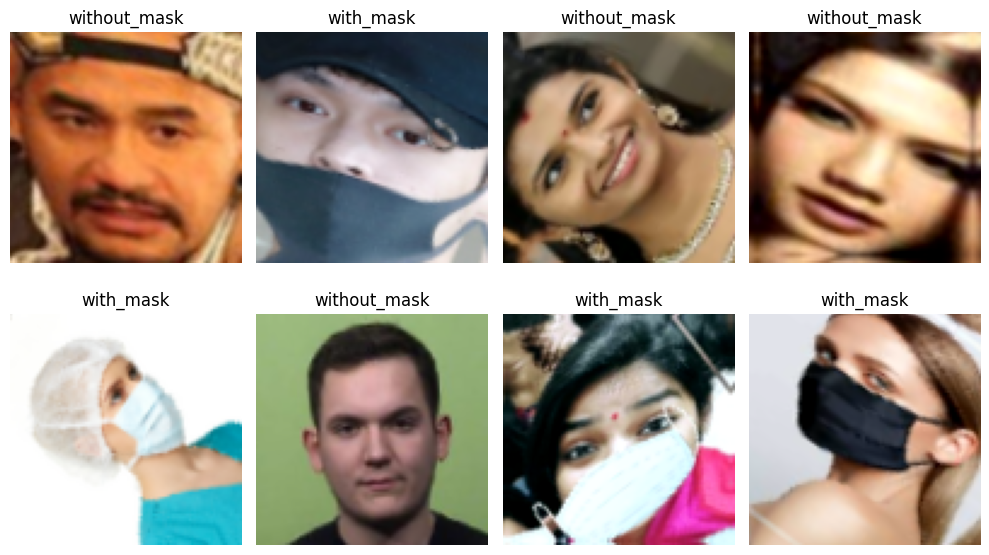

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

# Pipeline de Aumento de Dados
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

def preprocess_train(image, label):
    # Aplica augmentation
    image = data_augmentation(image)
    # Normaliza para [-1, 1] (padrão MobileNetV2)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_val(image, label):
    # Apenas normaliza
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Aplica as transformações
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

plt.figure(figsize=(10, 6))
for images, labels in train_dataset.take(1):
    for i in range(min(8, len(images))):
        img = (images[i] + 1) / 2
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

## 5. 🏗️ Construção do Modelo



### Arquitetura Escolhida

- **Base**: MobileNetV2 (Alpha=0.35 para extrema leveza).

- **Top**: Cabeçalho personalizado com Dropout agressivo para regularização.



In [ ]:
print("🏗️ Construindo o modelo...")

# Carrega a MobileNetV2 sem o topo (include_top=False)
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    alpha=0.35
)

# Congela a base inicialmente
base_model.trainable = False

# Adiciona o novo cabeçalho (Head)
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout alto para evitar overfitting na feature extraction
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

# Compilação
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


🏗️ Construindo o modelo...


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,434 (2.19 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 410,208 (1.56 MB)

## 6. 🚀 Fase 1: Feature Extraction

Treinamos apenas as novas camadas (cabeçalho). A base MobileNetV2 permanece congelada.



In [39]:
# Callbacks para controle de treino
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
)

print("\n🚀 Iniciando Fase 1: Feature Extraction (Base Congelada)...")

history_phase1 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)



🚀 Iniciando Fase 1: Feature Extraction (Base Congelada)...
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.8686 - loss: 0.3136 - val_accuracy: 0.9669 - val_loss: 0.0965 - learning_rate: 0.0010
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9133 - loss: 0.2145 - val_accuracy: 0.9702 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9226 - loss: 0.1966 - val_accuracy: 0.9735 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9255 - loss: 0.1835 - val_accuracy: 0.9735 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9322 - loss: 0.1727 - val_accuracy: 0.9728 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9330 - loss: 0.1682 - val_accuracy: 0.9728 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 7/10
189/

## 7. 🔧 Fase 2: Fine-Tuning

Descongelamos as camadas superiores da base para ajustar os pesos às especificidades do nosso problema (máscaras).



> ⚠️ **Importante**: Usamos um Learning Rate muito menor (1e-5) para não destruir o que já foi aprendido.



In [ ]:
print("\n🔧 Iniciando Fase 2: Fine-Tuning...")

base_model.trainable = True

for layer in base.layers[:-20]:
    layer.trainable = False

# Recompila com LR baixo
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

model.summary()

history_phase2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)



🔧 Iniciando Fase 2: Fine-Tuning...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,434 (2.19 MB)

 Trainable params: 498,082 (1.90 MB)

 Non-trainable params: 76,352 (298.25 KB)

Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.8185 - loss: 0.5268 - val_accuracy: 0.9722 - val_loss: 0.0680 - learning_rate: 1.0000e-05
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.8823 - loss: 0.3199 - val_accuracy: 0.9695 - val_loss: 0.0752 - learning_rate: 1.0000e-05
Epoch 12/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8948 - loss: 0.2677
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9027 - loss: 0.2465 - val_accuracy: 0.9689 - val_loss: 0.0800 - learning_rate: 1.0000e-05
Epoch 13/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9189 - loss: 0.2180 - val_accuracy: 0.9702 - val_loss: 0.0759 - learning_rate: 5.0000e-06
Epoch 14/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9219 - loss: 0.1989 - val_accuracy: 0.9728 - val_loss: 0.0719 - learning_rate: 5.0000e-06
Epoch 14: early stopping
Restoring model weigh

## 8. 📊 Análise de Resultados

Combinamos os históricos das duas fases para visualizar a evolução completa.



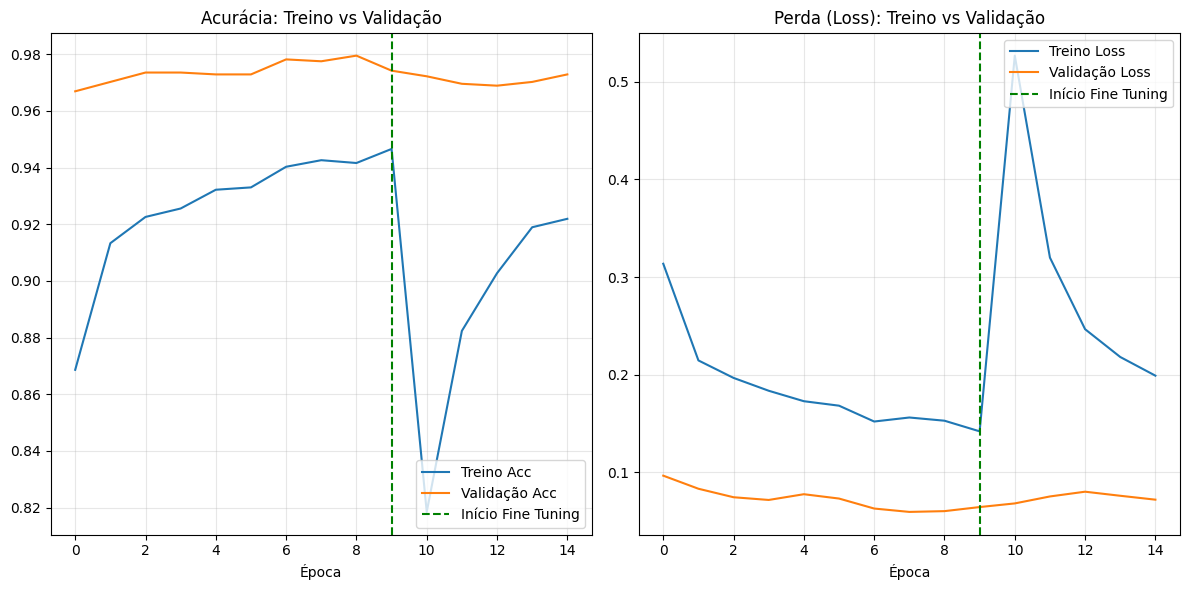


📊 Diagnóstico Final:
   Acurácia Treino: 92.19%
   Acurácia Validação: 97.28%
   GAP: -5.10%
✅ Modelo Generalizando Bem!


In [41]:
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(12, 6))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino Acc')
plt.plot(val_acc, label='Validação Acc')
plt.axvline(x=len(history_phase1.history['accuracy'])-1, color='green', linestyle='--', label='Início Fine Tuning')
plt.legend(loc='lower right')
plt.title('Acurácia: Treino vs Validação')
plt.xlabel('Época')
plt.grid(True, alpha=0.3)

# Perda
plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino Loss')
plt.plot(val_loss, label='Validação Loss')
plt.axvline(x=len(history_phase1.history['accuracy'])-1, color='green', linestyle='--', label='Início Fine Tuning')
plt.legend(loc='upper right')
plt.title('Perda (Loss): Treino vs Validação')
plt.xlabel('Época')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnóstico de Overfitting
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
gap = final_train_acc - final_val_acc

print(f"\n📊 Diagnóstico Final:")
print(f"   Acurácia Treino: {final_train_acc*100:.2f}%")
print(f"   Acurácia Validação: {final_val_acc*100:.2f}%")
print(f"   GAP: {gap*100:.2f}%")

if gap > 0.10:
    print("⚠️ ALERTA: Possível Overfitting (Gap > 10%)")
else:
    print("✅ Modelo Generalizando Bem!")


## 9. 🧪 Teste Externo (Prova Real)

Validamos o modelo com um dataset TOTALMENTE NOVO que o modelo nunca viu, para garantir que ele funciona no mundo real.



**Dataset de Teste**: [Face Mask Dataset (External)](https://www.kaggle.com/datasets/belsonraja/face-mask-dataset-with-and-without-mask)



In [42]:
print("\n🌍 Baixando Dataset de Teste Externo...")
test_path = kagglehub.dataset_download("belsonraja/face-mask-dataset-with-and-without-mask")
TEST_DIR = os.path.join(test_path, "facemask-dataset", "dataset")

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Aplica apenas o preprocessamento de validação (normalização)
test_dataset = test_dataset.map(preprocess_val).prefetch(AUTOTUNE)

print("\n🧪 Avaliando no Dataset Externo...")
external_loss, external_acc = model.evaluate(test_dataset)
print(f"🏆 Acurácia no Teste Externo: {external_acc*100:.2f}%")



🌍 Baixando Dataset de Teste Externo...
Found 3833 files belonging to 2 classes.

🧪 Avaliando no Dataset Externo...
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9760 - loss: 0.0631
🏆 Acurácia no Teste Externo: 97.60%


### 9.1 Visualização das Predições



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


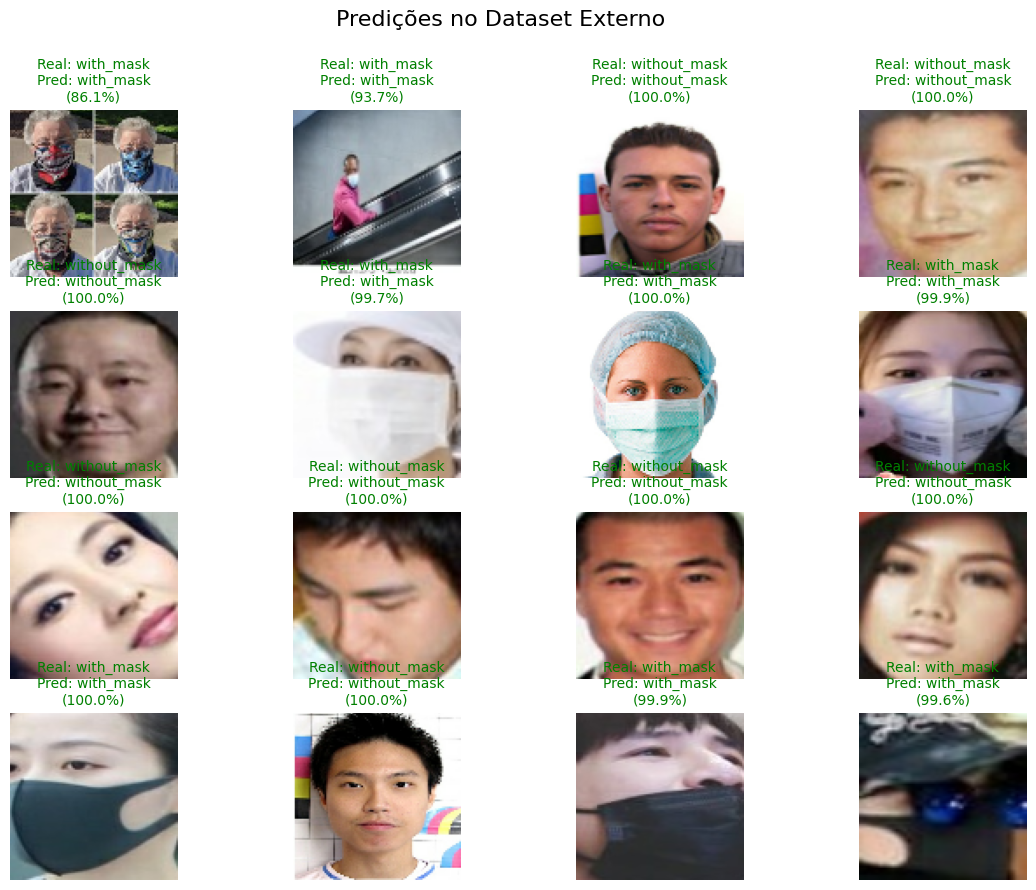

In [43]:
# Pega um batch de imagens
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

test_class_names = class_names # Usamos os nomes das classes salvos anteriormente

plt.figure(figsize=(14, 10))
for i in range(min(16, len(image_batch))):
    ax = plt.subplot(4, 4, i + 1)
    
    # Desnormaliza para mostrar
    img_show = (image_batch[i] + 1) / 2
    plt.imshow(img_show)
    
    true_label = test_class_names[label_batch[i]]
    pred_label = test_class_names[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    
    color = "green" if true_label == pred_label else "red"
    
    plt.title(f"Real: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis("off")
plt.suptitle("Predições no Dataset Externo", fontsize=16)
plt.show()


## 10. 💾 Exportação do Modelo

Salvamos o modelo em formato Keras e convertemos para **TFLite Quantizado (INT8)**, ideal para microcontroladores como o ESP32.



In [44]:
# Salva modelo Keras padrão
model.save("mask_detector_float.keras")
print("\n✅ Modelo salvo: mask_detector_float.keras")

# Salva SavedModel para conversão
tf.saved_model.save(model, "mask_detector_savedmodel")

# Função geradora para dataset representativo (Necessário para Quantização INT8)
def representative_data_gen():
    for input_value, _ in train_dataset.take(100):
        # O modelo espera float32 input, mas a quantização vai mapear range de valores
        yield [input_value]

# Conversão TFLite
print("\n🔄 Convertendo para TFLite INT8...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Garante compatibilidade total INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Salva arquivo .tflite
tflite_path = "mask_detector_int8.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

size_kb = os.path.getsize(tflite_path) / 1024
print(f"✅ Modelo TFLite salvo: {tflite_path}")
print(f"📦 Tamanho Final: {size_kb:.2f} KB")



✅ Modelo salvo: mask_detector_float.keras
INFO:tensorflow:Assets written to: mask_detector_savedmodel\assets


INFO:tensorflow:Assets written to: mask_detector_savedmodel\assets



🔄 Convertendo para TFLite INT8...
INFO:tensorflow:Assets written to: C:\Users\josel\AppData\Local\Temp\tmppjqio9mn\assets


INFO:tensorflow:Assets written to: C:\Users\josel\AppData\Local\Temp\tmppjqio9mn\assets


Saved artifact at 'C:\Users\josel\AppData\Local\Temp\tmppjqio9mn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_662')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2004089209872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002451587024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027665232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002451588176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002451588752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027665040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027660432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027661968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027664464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2003027661776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  200

c:\Users\josel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Modelo TFLite salvo: mask_detector_int8.tflite
📦 Tamanho Final: 770.68 KB
